# Table of contents
* [Preparing the data and plots](#preparing)
* [Psychometric function](#psychometrics)
* [Probability of CoM trials](#p_com)
* [Probability of CoM trials depending on initation times](#p_com_IT)
* [Probability of CoM trials (obsolete)](#p_com_obsolete)

<a name="preparing"></a>
# Preparing data and plots
First, we import the basic modules and read the data (assuming it's already pre-processed). Change the path to the files if necessary 

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import random
import data_reader, data_analyser, trajectory_plotter

dr = data_reader.DataReader()
exp_1, exp_2 = 'Exp 1', 'Exp 2'
choices_1, dynamics_1 = dr.get_data(path='../../data/HEM_exp_1/processed/', rename_vars=True, IT_threshold=1.5)
choices_2, dynamics_2 = dr.get_data(path='../../data/HEM_exp_2/processed/', rename_vars=True, IT_threshold=1.5)
choices = choices_2

#set precision for displaying float-point values in the notebook
pd.options.display.float_format = '{:,.3f}'.format

# color palette for participant IDs
palette_subj = 'magma_r'

<a name="psychometrics"></a>
# Psychometric function (CoM vs non-CoM)

Plot individual psychometric functions separately for CoM and non-CoM trials

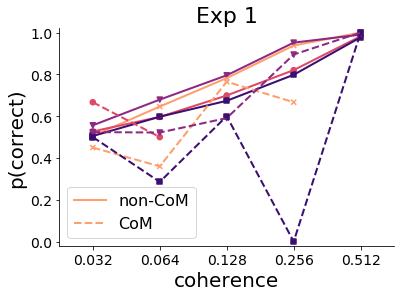

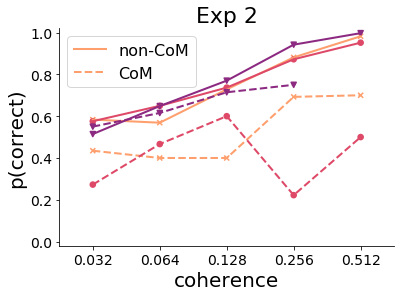

In [2]:
def plot_psychometric_function_individual(c, color, marker):
    psf = [len(c[(c.is_correct) & (c.coherence==coherence) & (c.is_com==is_com)]) / 
                   len(c[(c.coherence==coherence) & (c.is_com==is_com)]) 
               if len(c[(c.coherence==coherence) & (c.is_com==is_com)]) else np.NaN 
           for coherence in np.sort(c.coherence.unique()) 
           for is_com in np.sort(c.is_com.unique())]
    
    p_correct = pd.DataFrame(psf, columns=['p_correct'], 
                        index=pd.MultiIndex.from_product([np.sort(c.coherence.unique()), 
                                                          np.sort(c.is_com.unique())], 
                                                         names=['coherence', 'is_com']))
    
    ax = sns.pointplot(data=p_correct.reset_index(), x='coherence', y='p_correct', hue='is_com',
                       palette=[color, color], linestyles=['-', '--'], markers=[marker, marker], 
                       scale=0.75)
    
    ax.set_xlabel('coherence')
    ax.set_ylabel('p(correct)')
    ax.legend(handles=ax.lines[::len(c.coherence.unique())+1], labels=['non-CoM','CoM'])
    
    return ax

def plot_psychometric_functions(choices, exp):
    plt.figure()
    choices = choices[~(choices.coherence==0)]
#     colors = ['C0', 'C1', 'C2', 'C3']
    markers = ['x','o','v','s']
    colors = sns.color_palette(palette_subj, 4)
    for i, subj_id in enumerate(np.sort(choices.index.get_level_values('subj_id').unique().values)):
        ax = plot_psychometric_function_individual(choices.loc[subj_id], color=colors[i], marker=markers[i])
    ax.set_ylim([-0.02, 1.02])
    plt.title(exp)
    plt.savefig(('figures/psychometric_function_individual_%s' % (exp)).replace(' ', '_'), bbox_inches='tight')

plot_psychometric_functions(choices_1, exp_1)
plot_psychometric_functions(choices_2, exp_2)

Note that as Participant 275 has very few CoMs, their psychometric function is very noisy, especially at higher coherence levels. For this reason, we probably won't be able to fit the model to this individual, and also maybe Participant 451. If we don't do individual fits though, we can just fit to psychometric function calculated for all participant within an experiment. This is what it looks like

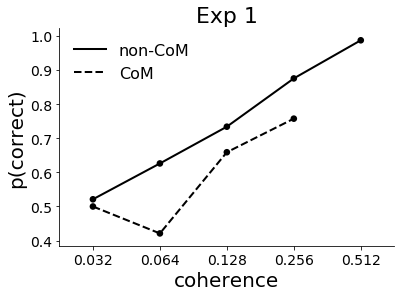

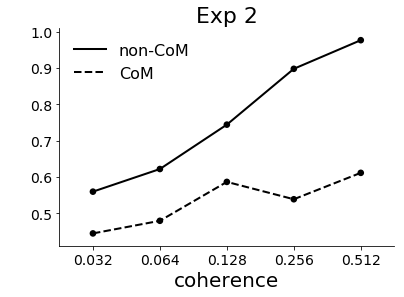

In [3]:
def plot_psychometric_function_aggregate(c, exp, n_threshold=0, color='k'):
    plt.figure()
    c = c[~(c.coherence==0)]
    psf = [len(c[(c.is_correct) & (c.coherence==coherence) & (c.is_com==is_com)]) / 
                   len(c[(c.coherence==coherence) & (c.is_com==is_com)]) 
               if len(c[(c.coherence==coherence) & (c.is_com==is_com)]) > n_threshold else np.NaN  
           for coherence in np.sort(c.coherence.unique()) 
           for is_com in np.sort(c.is_com.unique())]
    
    p_correct = pd.DataFrame(psf, columns=['p_correct'], 
                        index=pd.MultiIndex.from_product([np.sort(c.coherence.unique()), 
                                                          np.sort(c.is_com.unique())], 
                                                         names=['coherence', 'is_com']))
    ax = sns.pointplot(data=p_correct.reset_index(), x='coherence', y='p_correct', hue='is_com',
                       palette=[color, color], linestyles=['-', '--'], scale = 0.75)
    
    ax.set_xlabel('coherence')
    ax.set_ylabel('p(correct)' if exp=='Exp 1' else ' ')
        
    ax.legend(handles=ax.lines[::len(c.coherence.unique())+1], labels=['non-CoM','CoM'], frameon=False)
    plt.title(exp)
    ax.axhline(0.5, xmin=1, xmax=5, lw=1, color='gray')
    plt.savefig(('figures/psychometric_function_%s' % (exp)).replace(' ', '_'), bbox_inches='tight')
    return ax

plot_psychometric_function_aggregate(choices_1, exp_1, n_threshold=5)
plot_psychometric_function_aggregate(choices_2, exp_2, n_threshold=5)

Let's look at the same psychometric functions with [binomial proportion confidence intervals](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval). 

Following Resulaj et al (2009), whiskers denote s.e.m. (rather than 95% CI).

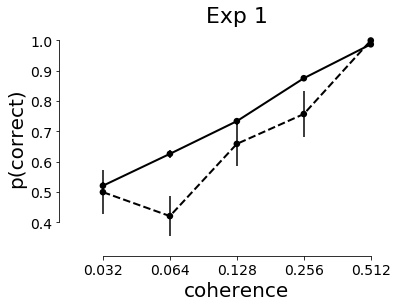

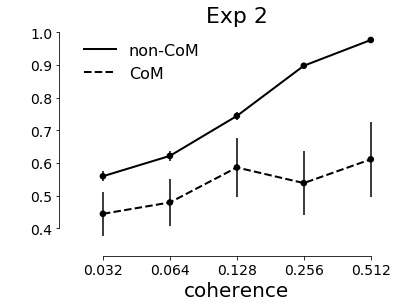

In [4]:
def get_ci(c, n_threshold=0):
    psf = np.array([len(c[(c.is_correct) & (c.coherence==coherence) & (c.is_com==is_com)]) / 
                   len(c[(c.coherence==coherence) & (c.is_com==is_com)]) 
               if len(c[(c.coherence==coherence) & (c.is_com==is_com)]) > n_threshold else np.NaN  
           for coherence in np.sort(c.coherence.unique()) 
           for is_com in np.sort(c.is_com.unique())])
    n = [len(c[(c.coherence==coherence) & (c.is_com==is_com)]) 
                      for coherence in np.sort(c.coherence.unique()) 
                      for is_com in np.sort(c.is_com.unique())]

    ci = pd.DataFrame(psf, columns=['p_correct'], 
                        index=pd.MultiIndex.from_product([np.sort(c.coherence.unique()), 
                                                          np.sort(c.is_com.unique())], 
                                                         names=['coherence', 'is_com']))
    ci['ci_l'] = ci['p_correct'] - np.sqrt(psf*(1-psf)/n)
    ci['ci_r'] = ci['p_correct'] + np.sqrt(psf*(1-psf)/n)
    
    return ci.reset_index()

def plot_psychometric_function_ci(choices, exp, n_threshold=0):
    choices = choices[~(choices.coherence==0)]
    ax = plot_psychometric_function_aggregate(choices, exp, n_threshold=n_threshold)
    ci = get_ci(choices)
    ax.vlines(x=[val for pair in zip(range(0,5), range(0,5)) for val in pair], 
              ymin=ci.ci_l, ymax=ci.ci_r, color='k', zorder=10)
    plt.title(exp)
    
    ax.get_yaxis().set_major_locator(mpl.ticker.FixedLocator(np.linspace(0.4, 1.0, 7)))
    sns.despine(ax=ax, trim=True, offset=10)
    
    if exp=='Exp 1':
        ax.legend_.remove()
    
    plt.savefig(('figures/psychometric_function_com_ci_%s' % (exp)).replace(' ', '_'), bbox_inches='tight')
    
plot_psychometric_function_ci(choices_1, exp_1, n_threshold=1)
plot_psychometric_function_ci(choices_2, exp_2, n_threshold=1)

# Psychometric function (initial vs final)

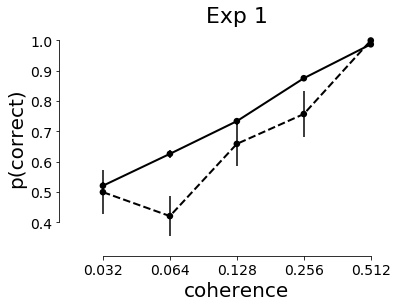

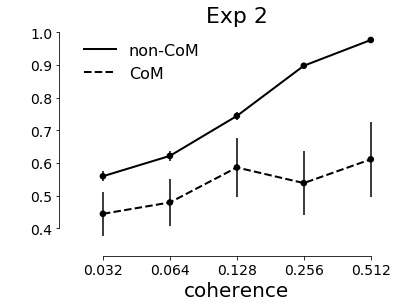

In [5]:
def plot_psychometric_function_aggregate_initial(c, exp, color='k'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    offset = np.logspace(-3, -2, 5)
    
    psf_init = c.groupby('coherence').apply(lambda c: len(c[c.is_correct_init])/len(c)).rename('p_correct').reset_index()
    ax.plot(psf_init.coherence-offset, psf_init.p_correct, color=color, ls='', marker='^', label='Initial', ms=5)
    
    psf_final = c.groupby('coherence').apply(lambda c: len(c[c.is_correct])/len(c)).rename('p_correct').reset_index()
    ax.plot(psf_final.coherence+offset, psf_final.p_correct, color='red', ls='', marker='o', label='Final', ms=5)
    
    ax.set_xlabel('coherence')
    ax.set_ylabel('p(correct)')    
    ax.set_xscale('log')
    
    ax.set_xticks(np.sort(choices.coherence.unique()))
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.get_xaxis().set_minor_locator(mpl.ticker.NullLocator())
    ax.legend(frameon=False)
    plt.title(exp)
#     plt.savefig('figures/psychometric_function_%s' % (exp), bbox_inches='tight')
    return ax

def get_ci_initial(c, correct_col):
    psf = np.array([len(c[(c[correct_col]) & (c.coherence==coherence)])/len(c[(c.coherence==coherence)]) 
                    for coherence in np.sort(c.coherence.unique())])       
    ci = pd.DataFrame(psf, index=np.sort(c.coherence.unique()), columns=['p_correct'])
    
    n = [len(c[(c.coherence==coherence)]) for coherence in np.sort(c.coherence.unique())]
    ci['ci_l'] = ci['p_correct'] - np.sqrt(psf*(1-psf)/n)
    ci['ci_r'] = ci['p_correct'] + np.sqrt(psf*(1-psf)/n)
    
    return ci.reset_index()

def plot_psychometric_function_ci_initial(choices, exp):
    offset = np.logspace(-3, -2, 5)
    
    choices = choices[~(choices.coherence==0)]
    
    ax = plot_psychometric_function_aggregate(choices, exp)
    ci = get_ci(choices, 'is_correct_init')
    ax.vlines(x=np.sort(choices.coherence.unique())-offset, ymin=ci.ci_l, ymax=ci.ci_r, color='k', zorder=10)
    
    ci = get_ci(choices, 'is_correct')
    ax.vlines(x=np.sort(choices.coherence.unique())+offset, ymin=ci.ci_l, ymax=ci.ci_r, color='r', zorder=10)
    ax.get_yaxis().set_major_locator(mpl.ticker.FixedLocator(np.linspace(0.5, 1.0, 6)))
    plt.title(exp)
    ax.set_ylim(0.45, 1.05)
    sns.despine(ax=ax, trim=True, offset=10)
    plt.savefig(('figures/psychometric_function_ci_%s' % (exp)).replace(' ', '_'), bbox_inches='tight')
    
plot_psychometric_function_ci(choices_1, exp_1)
plot_psychometric_function_ci(choices_2, exp_2)

<a name="p_com"></a>
# Probability of CoM

First, let's take a look at number of correct/error CoM at each coherence level

Exp 1                       n_com
coherence is_correct       
0.032     False          23
          True           23
0.064     False          33
          True           24
0.128     False          15
          True           29
0.256     False           8
          True           25
0.512     False           0
          True            2
Exp 1 Total CoM: 0.024
Exp 2                       n_com
coherence is_correct       
0.032     False          30
          True           24
0.064     False          25
          True           23
0.128     False          12
          True           17
0.256     False          12
          True           14
0.512     False           7
          True           11
Exp 2 Total CoM: 0.030


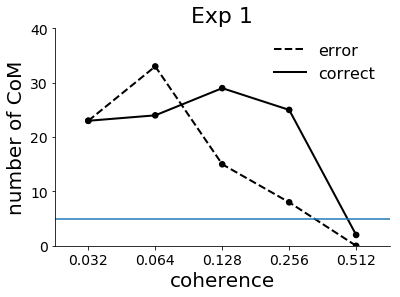

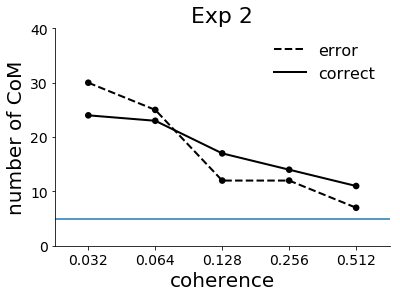

In [6]:
def plot_n_com_by_is_correct(c, exp, color='k'):
    plt.figure()
    c = c[~(c.coherence==0)]
    n_com = [len(c[(c.is_com) & (c.coherence==coherence) & (c.is_correct==is_correct)])
           for coherence in np.sort(c.coherence.unique()) 
           for is_correct in np.sort(c.is_correct.unique())]
    
    n_com = pd.DataFrame(n_com, columns=['n_com'], 
                        index=pd.MultiIndex.from_product([np.sort(c.coherence.unique()), 
                                                          np.sort(c.is_correct.unique())], 
                                                         names=['coherence', 'is_correct']))
    ax = sns.pointplot(data=n_com.reset_index(), x='coherence', y='n_com', hue='is_correct',
                       palette=[color, color], linestyles=['--', '-'], scale = 0.75)
    
    print(exp, n_com)
    print(exp, 'Total CoM: %.3f' % (len(c[c.is_com])/len(c)))
    ax.axhline(5)
    ax.set_xlabel('coherence')
    ax.set_ylabel('number of CoM')
    ax.set_ylim((0, 40))
    ax.legend(handles=ax.lines[::len(c.coherence.unique())+1], labels=['error','correct'], frameon=False)
    plt.title(exp)
    plt.savefig(('figures/n_com_by_is_correct_%s' % (exp).replace(' ', '_')), bbox_inches='tight')
    return ax

plot_n_com_by_is_correct(choices_1, exp_1)
plot_n_com_by_is_correct(choices_2, exp_2)

In Experiment 1 we have fewer CoM's at higher coherences, compared to Experiment 2. For instance, at 0.512 coherence we have just 3 CoM's in Exp 1, and 20 CoM's in Exp 2. Naturally, with these numbers p(CoM) is going to be very noisy, so we discard the conditions with less than 5 data points (below blue lines in the plots above)

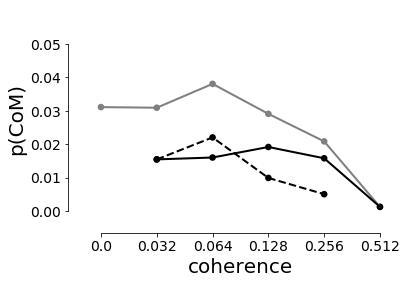

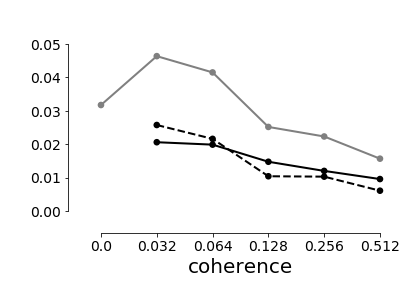

In [7]:
def plot_p_com_by_is_correct(c, exp, correct_col='is_correct', color='k', n_threshold = 5):
    plt.figure()

    p_com_total = [(len(c[(c.is_com) & (c.coherence==coherence)]) / len(c[(c.coherence==coherence)]), coherence)
               if (len(c[(c.is_com) & (c.coherence==coherence)]) > n_threshold) else (np.NaN, coherence)
           for coherence in np.sort(c.coherence.unique())]
    
    p_com_total = pd.DataFrame(p_com_total, columns=['p_com', 'coherence'])
    
    ax = sns.pointplot(data=p_com_total, x='coherence', y='p_com', scale=0.75, color='gray')
    
#     c = c[~(c.coherence==0)]
    p_com = [len(c[(c.is_com) & (c.coherence==coherence) & (c[correct_col]==is_correct)]) / 
                   len(c[(c.coherence==coherence)]) 
               if (len(c[(c.is_com) & (c.coherence==coherence) & (c[correct_col]==is_correct)]) > n_threshold) else np.NaN  
           for coherence in np.sort(c.coherence.unique()) 
           for is_correct in np.sort(c[correct_col].unique())]
    
    p_com = pd.DataFrame(p_com, columns=['p_com'], 
                        index=pd.MultiIndex.from_product([np.sort(c.coherence.unique()), 
                                                          np.sort(c.is_correct.unique())], 
                                                         names=['coherence', correct_col]))
    p_com.loc[0] = np.NaN
   
    ax = sns.pointplot(data=p_com.reset_index(), x='coherence', y='p_com', hue=correct_col,
                       palette=[color, color], linestyles=['--', '-'], scale=0.75, ax=ax)
        
    ax.set_xlabel('coherence')
    ax.set_ylabel('p(CoM)' if exp=='Exp 1' else ' ')
    ax.set_ylim((-0.005, 0.06))
    sns.despine(ax=ax, trim=True, offset=5)
    ax.legend_.remove()
#     plt.title(exp)
    plt.savefig(('figures/p_com_by_%s_%s' % (correct_col, exp)).replace(' ', '_'), bbox_inches='tight')
    return ax

plot_p_com_by_is_correct(choices_1, exp_1, n_threshold=0)
plot_p_com_by_is_correct(choices_2, exp_2, n_threshold=0)

We can also take a look at unfiltered data, and indicate uncertainty with confidence intervals  like we did in the psychometric function plots

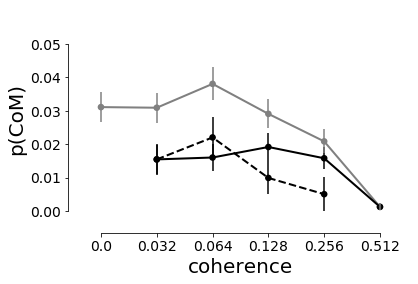

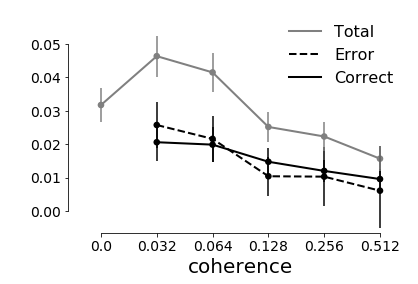

In [8]:
def get_ci_p_com(c, correct_col='choice', n_threshold=10):
    p_com = np.array([len(c[(c.is_com) & (c.coherence==coherence) & (c[correct_col]==is_correct)]) / 
                   len(c[(c.coherence==coherence)]) 
               if (len(c[(c.is_com) & (c.coherence==coherence) & (c[correct_col]==is_correct)])>n_threshold) else np.NaN  
           for coherence in np.sort(c.coherence.unique()) 
           for is_correct in np.sort(c[correct_col].unique())])
    n = [len(c[(c.coherence==coherence) & (c[correct_col]==is_correct)]) 
                      for coherence in np.sort(c.coherence.unique()) 
                      for is_correct in np.sort(c[correct_col].unique())]

    ci = pd.DataFrame(p_com, columns=['p_com'], 
                        index=pd.MultiIndex.from_product([np.sort(c.coherence.unique()), 
                                                          np.sort(c[correct_col].unique())], 
                                                         names=['coherence', correct_col]))
    ci['ci_l'] = ci['p_com'] - np.sqrt(p_com*(1-p_com)/n)
    ci['ci_r'] = ci['p_com'] + np.sqrt(p_com*(1-p_com)/n)
    
    return ci.reset_index()

def get_ci_p_com_total(c, n_threshold=10):
    p_com_total = [(len(c[(c.is_com) & (c.coherence==coherence)]) / len(c[(c.coherence==coherence)]), coherence)
               if (len(c[(c.is_com) & (c.coherence==coherence)]) > n_threshold) else (np.NaN, coherence)
           for coherence in np.sort(c.coherence.unique())]
    
    n = [len(c[(c.coherence==coherence)]) for coherence in np.sort(c.coherence.unique())]
    
    ci = pd.DataFrame(p_com_total, columns=['p_com', 'coherence'])  
    
    p_com = ci.p_com
    ci['ci_l'] = ci['p_com'] - np.sqrt(p_com*(1-p_com)/n)
    ci['ci_r'] = ci['p_com'] + np.sqrt(p_com*(1-p_com)/n)
    
    return ci.reset_index()

def plot_p_com_ci(choices, exp, correct_col='is_correct', n_threshold=0, labels=[]):
    ax = plot_p_com_by_is_correct(choices, exp, correct_col, n_threshold=n_threshold)

    ci_total = get_ci_p_com_total(choices, n_threshold=n_threshold)
    ax.vlines(x=range(0,6), ymin=ci_total.ci_l, ymax=ci_total.ci_r, color='gray', zorder=20)
    
    ci = get_ci_p_com(choices, correct_col, n_threshold=n_threshold)
    ax.vlines(x=[val for pair in zip(range(1,6), range(1,6)) for val in pair], 
              ymin=ci[ci.coherence>0].ci_l, ymax=ci[ci.coherence>0].ci_r, color='k', zorder=10)

#     plt.title(exp)
    ax.set_ylim(-0.005, 0.06)
    
    if exp=='Exp 2':
        ax.legend(handles=ax.lines[::len(choices.coherence.unique())+1], labels=labels, frameon=False)
    
    plt.savefig(('figures/p_com_by_%s_ci_%s' % (correct_col, exp)).replace(' ', '_'), bbox_inches='tight')

labels=['Total','Error','Correct']
# labels=['Total', 'To correct', 'To error']
plot_p_com_ci(choices_1, exp_1, correct_col='is_correct', n_threshold=0, labels=labels)
plot_p_com_ci(choices_2, exp_2, correct_col='is_correct', n_threshold=0, labels=labels)

<a name="p_com_IT"></a>
# Probability of CoM trials depending on initiation times

Let's look at probability of CoM for trials with different initation times

In [9]:
def get_p_com_per_var(c, var):
    return np.array([(len(c[(c.is_com) & (c.coherence==coherence) & (c[var]==var_level)]) / 
                   len(c[(c.coherence==coherence)])) 
               if len(c[(c.coherence==coherence) & (c[var]==var_level)]) else np.NaN  
           for coherence in np.sort(c.coherence.unique())
           for var_level in np.sort(c[var].unique())])
    
def get_ci_vs_var(choices, var, n_threshold=0):
    # use this line when probability is to be calculated conditional on the IT tertile level
    p_com = (choices.groupby(by=['coherence', var])
             .apply(lambda c: len(c[c.is_com])/len(c) if len(c) else np.NaN)
             .rename('p_com'))
    # use this one when probability is to be calculated within coherence level across all IT tertiles
#     p_com = get_p_com_per_var(choices, var)    

    n = choices.groupby(by=['coherence', var]).apply(len)
    ci = pd.DataFrame(p_com, columns=['p_com'], 
                        index=pd.MultiIndex.from_product([np.sort(choices.coherence.unique()), 
                                                          np.sort(choices[var].unique())], 
                                                         names=['coherence', var]))
    ci['ci_l'] = ci['p_com'] - np.sqrt(p_com*(1-p_com)/n)
    ci['ci_r'] = ci['p_com'] + np.sqrt(p_com*(1-p_com)/n)

    return ci.reset_index()
    
def plot_p_com_vs_var_ci(choices, var, exp, palette='viridis_r', n_threshold=10):
    plt.figure()
    # this is needed to convert eye IT tertile from float to int
    choices[var] = choices[var].astype(int)
    ci = get_ci_vs_var(choices, var, n_threshold=n_threshold)

    ax = sns.pointplot(data=ci, x='coherence', y='p_com', hue=var, palette=palette)
    ax.vlines(x=[val for pair in zip(range(0,6), range(0,6), range(0,6)) for val in pair], 
              ymin=ci.ci_l, ymax=ci.ci_r, color='gray', zorder=0)

    if var=='hand IT tertile':
        plt.title(exp)
    ax.set_ylim(-0.005, 0.12)
    ax.set_ylabel('p(CoM)' if exp=='Exp 1' else ' ')
    sns.despine(ax=ax, trim=True, offset=5)
    if exp=='Exp 1':
        ax.legend_.remove()
    else:
        legend = ax.legend(loc='center left',bbox_to_anchor=(1, 0.5), frameon=False)
        legend.set_title(var, prop = {'size':'xx-large'})
    
    plt.savefig(('figures/p_com_by_%s_ci_%s' % (var, exp)).replace(' ', '_'), bbox_inches='tight')
    return ax

In Experiment 1, the pattern is opposite to that in SI Fig. 3 from Resulaj et al (2009). However, there is no such pattern in Experiment 2. This is possibly due to our manipulation of late responses in Exp 2. 

In constrast, changes-of-mind do become more frequent with longer initiation if we look at eye IT's

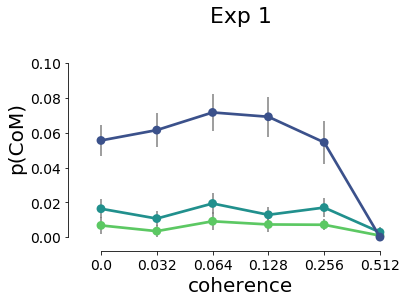

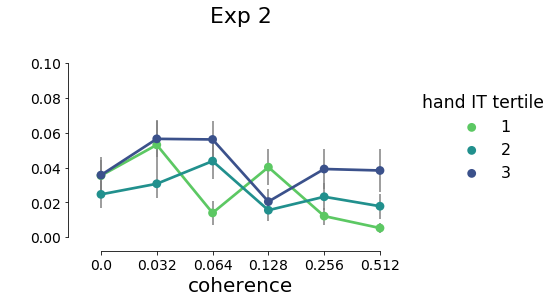

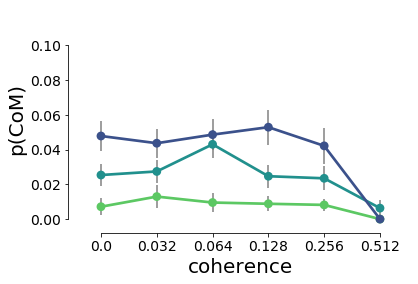

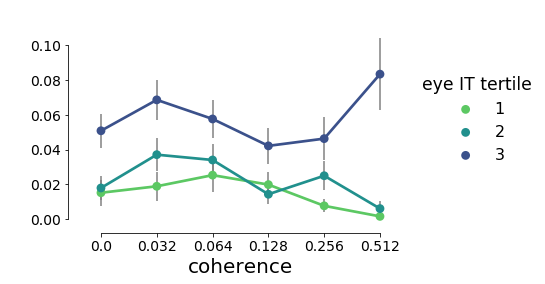

In [10]:
plot_p_com_vs_var_ci(choices_1, 'hand IT tertile', exp_1, n_threshold=0)
plot_p_com_vs_var_ci(choices_2, 'hand IT tertile', exp_2, n_threshold=0)

plot_p_com_vs_var_ci(choices_1[~choices_1['eye IT tertile'].isnull()], 'eye IT tertile', exp_1)
plot_p_com_vs_var_ci(choices_2[~choices_2['eye IT tertile'].isnull()], 'eye IT tertile', exp_2)

We can further split this into correct/error trials to obtain plots similar to SI Fig 3 in Resulaj et al (2009), but then we have too much noise, especially at high coherences

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


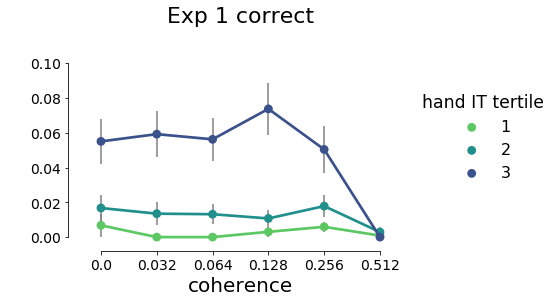

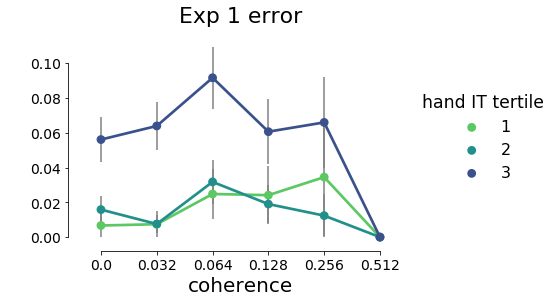

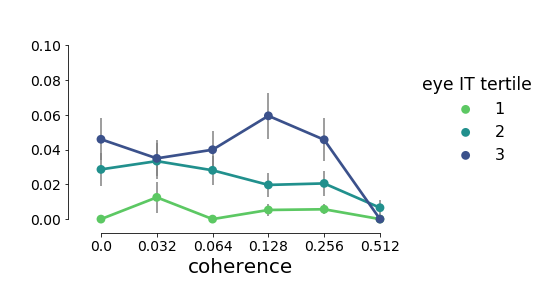

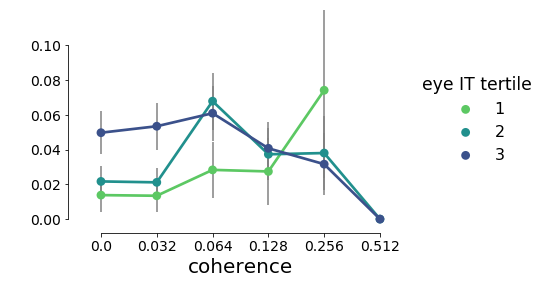

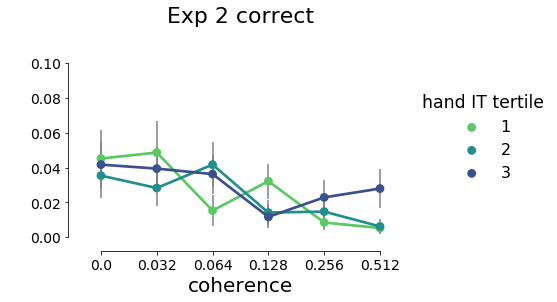

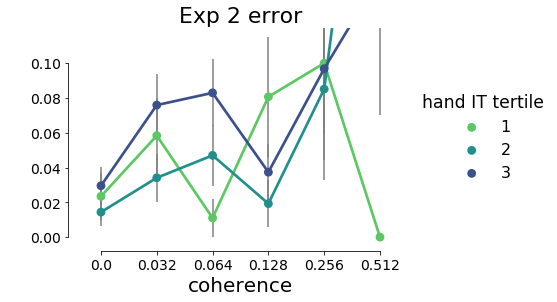

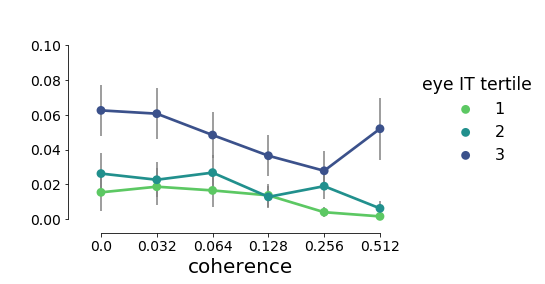

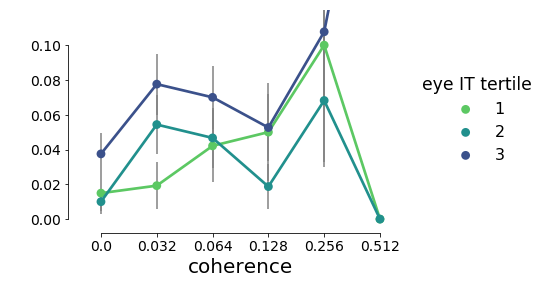

In [11]:
def plot_p_com_vs_coherence_by_var_by_is_correct(choices, exp):
    ax = plot_p_com_vs_var_ci(choices[(choices.is_correct) & (~choices['eye IT tertile'].isnull())], 
                              'hand IT tertile', exp+' correct')
    ax = plot_p_com_vs_var_ci(choices[(~choices.is_correct) & (~choices['eye IT tertile'].isnull())], 
                              'hand IT tertile', exp+' error')
#     ax.set_ylim(-0.01, 0.5)
    ax = plot_p_com_vs_var_ci(choices[(choices.is_correct) & (~choices['eye IT tertile'].isnull())], 
                              'eye IT tertile', exp+' correct')
    ax = plot_p_com_vs_var_ci(choices[(~choices.is_correct) & (~choices['eye IT tertile'].isnull())], 
                              'eye IT tertile', exp+' error')
#     ax.set_ylim(-0.01, 0.5)

plot_p_com_vs_coherence_by_var_by_is_correct(choices_1, exp_1)
plot_p_com_vs_coherence_by_var_by_is_correct(choices_2, exp_2)

<a name="p_com_obsolete"></a>
# Probability of CoM trials (obsolete)

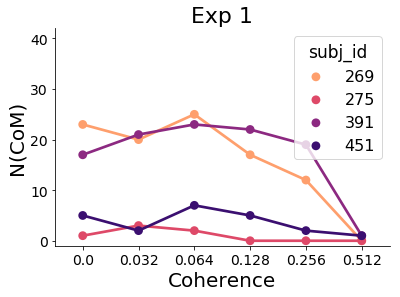

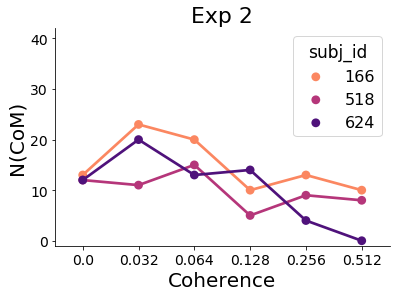

In [12]:
def plot_n_com_vs_coherence(choices, exp):
    plt.figure()
    com_count = choices.groupby(by=['subj_id', 'coherence']).apply(lambda c: len(c[c.is_com])).rename('com_count')
    ax = sns.pointplot(data=com_count.reset_index(), x='coherence', y='com_count', hue='subj_id', 
                       ci=None, scale=1, palette=palette_subj)
    ax.set_xlabel('Coherence')
    ax.set_ylabel('N(CoM)')
    ax.set_ylim([-1, 42])
    plt.title(exp)
    plt.savefig(('figures/n_com_vs_coherence_%s' % (exp)).replace(' ', '_'), bbox_inches='tight')

plot_n_com_vs_coherence(choices_1, exp_1)
plot_n_com_vs_coherence(choices_2, exp_2)

Overall proportion of CoM trials is:

In [31]:
print(len(choices_1[choices_1.is_com])/len(choices_1))
print(len(choices_2[choices_2.is_com])/len(choices_2))

0.02490986561783022
0.030464147147578675


Let's take a look at probability of change-of-mind for each individual participant

In [33]:
def print_p_com(choices):
    print(choices.groupby(level='subj_id').is_com.mean().rename('p_com').to_frame())
#     display(HTML(choices.groupby(level='subj_id').is_com.mean().rename('p_com').to_frame().
#                  to_html(formatters={'p_com': '{:,.1%}'.format})))

print_p_com(choices_1)
print_p_com(choices_2)

         p_com
subj_id       
269      0.041
275      0.003
391      0.051
451      0.009
         p_com
subj_id       
166      0.037
518      0.025
624      0.029


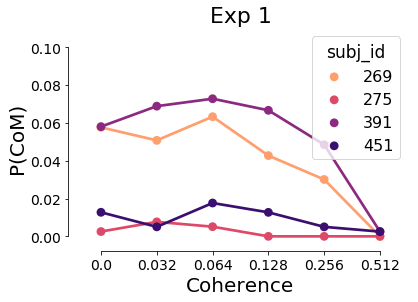

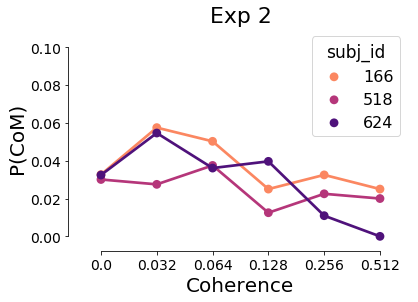

In [13]:
def plot_p_com_vs_coherence(choices, exp):
    plt.figure()
    p_com = choices.groupby(by=['subj_id', 'coherence']).apply(lambda c: len(c[c.is_com])/len(c)).rename('p_com')
    ax = sns.pointplot(data=p_com.reset_index(), x='coherence', y='p_com', hue='subj_id', ci=None, palette=palette_subj)
    ax.set_xlabel('Coherence')
    ax.set_ylabel('P(CoM)')
    ax.set_ylim([-0.005, 0.11])
    sns.despine(ax=ax, trim=True, offset=5)
    plt.title(exp)
    plt.savefig(('figures/p_com_vs_coherence_%s' % (exp)).replace(' ', '_'), bbox_inches='tight')

plot_p_com_vs_coherence(choices_1, exp_1)
plot_p_com_vs_coherence(choices_2, exp_2)